# Chef Classifier

## 1. Imports and Setup

In [1]:
import pandas as pd
import ast
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import re
import os
import nltk
from nltk.corpus import wordnet  # for synonyms
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.decomposition import PCA



nltk.download('wordnet')
os.environ["TOKENIZERS_PARALLELISM"] = "False"


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/arthurchau/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Load and Prepare Data

In [2]:
df = pd.read_csv('./train.csv', sep=';')
df['tags'] = df['tags'].apply(ast.literal_eval)
df['description'] = df['description'].fillna('')

# aug functions
def get_synonym(word):
    """Return a random synonym using WordNet."""
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            candidate = lemma.name().replace('_', ' ')
            if candidate.lower() != word.lower() and len(candidate.split()) == 1:
                synonyms.add(candidate)
    if synonyms:
        return np.random.choice(list(synonyms))
    return word


def synonym_replace(text, replacement_prob=0.15):
    words = text.split()
    if len(words) < 5:
        return text
    new_words = [
        get_synonym(w) if np.random.rand() < replacement_prob else w
        for w in words
    ]
    return ' '.join(new_words)


def random_delete(text, deletion_prob=0.05):
    words = text.split()
    if len(words) < 5:
        return text
    kept = [w for w in words if np.random.rand() > deletion_prob]
    return ' '.join(kept) if len(kept) > 3 else text


def sentence_shuffle(text):
    sentences = re.split(r'(?<=[.!?])\s+', text)
    if len(sentences) < 3:
        return text
    np.random.shuffle(sentences)
    return ' '.join(sentences)


def augment_text(text):
    r = np.random.rand()
    if r < 0.5:
        return synonym_replace(text)
    elif r < 0.75:
        return random_delete(text)
    else:
        return sentence_shuffle(text)


def augment_tags(tag_list):
    """Slightly modify tags for diversity (swap or drop)."""
    if not isinstance(tag_list, list) or len(tag_list) == 0:
        return tag_list
    new_tags = tag_list.copy()
    # 10% chance to remove one tag
    if np.random.rand() < 0.1 and len(new_tags) > 1:
        del new_tags[np.random.randint(0, len(new_tags))]
    # 10% chance to duplicate another
    if np.random.rand() < 0.1:
        new_tags.append(np.random.choice(new_tags))
    return list(set(new_tags))


# balancing chef data
def balance_and_augment(df, label_col='chef_id', id_col='orig_id'):
    """Upsample minority chefs with text+tag augmentation, tracking lineage."""
    assert id_col in df.columns, f"{id_col} must be present before augmenting."

    label_counts = df[label_col].value_counts()
    max_count = label_counts.max()
    augmented_rows = []

    print("\nCurrent class distribution:")
    print(label_counts.sort_index())
    print(f"→ Target per class: {max_count}\n")

    for chef, count in label_counts.items():
        if count < max_count:
            n_to_add = max_count - count
            chef_df = df[df[label_col] == chef]
            sampled = chef_df.sample(n=n_to_add, replace=True, random_state=42).copy()

            # lineage + flags
            sampled['parent_id'] = sampled[id_col]
            sampled['is_augmented'] = True

            # apply augments
            sampled['description'] = sampled['description'].apply(augment_text)
            sampled['tags'] = sampled['tags'].apply(augment_tags)

            augmented_rows.append(sampled)
            print(f"↑ Augmented class {chef}: +{n_to_add} samples")

    base = df.copy()
    base['parent_id'] = base[id_col]
    base['is_augmented'] = False

    if augmented_rows:
        df_aug = pd.concat([base] + augmented_rows, ignore_index=True)
        print(f"\nAdded total augmented samples: {sum(len(r) for r in augmented_rows)}")
        print(f"New total dataset size: {len(df_aug)}")
        print("=====================================\n")
        return df_aug
    else:
        print("No augmentation performed — already balanced.\n")
        return base
    
# Split before aug (keep validation clean)
X_raw = df[['description', 'tags', 'chef_id']].copy()

X_train_raw, X_val_raw = train_test_split(
    X_raw, test_size=0.2, random_state=4, stratify=X_raw['chef_id']
)

assert not set(X_train_raw.index).intersection(set(X_val_raw.index)), "Leakage detected between train and val!"


# Reset indices
X_train_raw = X_train_raw.reset_index(drop=True)
X_val_raw = X_val_raw.reset_index(drop=True)
X_train_raw['orig_id'] = X_train_raw.index

print(f"Original training samples: {len(X_train_raw)}")

# aug only training set
X_train_aug = balance_and_augment(X_train_raw)
print(f"Training samples after augmentation: {len(X_train_aug)}")




Original training samples: 2399

Current class distribution:
chef_id
1533    323
3288    361
4470    645
5060    427
6357    298
8688    345
Name: count, dtype: int64
→ Target per class: 645

↑ Augmented class 5060: +218 samples
↑ Augmented class 3288: +284 samples
↑ Augmented class 8688: +300 samples
↑ Augmented class 1533: +322 samples
↑ Augmented class 6357: +347 samples

Added total augmented samples: 1471
New total dataset size: 3870

Training samples after augmentation: 3870


## 3. Generate Embeddings for Descriptions

In [3]:
embedding_model = SentenceTransformer('all-mpnet-base-v2')  # 768 dim
mini_embedding_model = SentenceTransformer('all-MiniLM-L6-v2') # 384 dim

# Encode augmented train and untouched val descriptions
desc_train_emb = embedding_model.encode(X_train_aug['description'].tolist(), show_progress_bar=True)
desc_val_emb   = embedding_model.encode(X_val_raw['description'].tolist(), show_progress_bar=True)

desc_train_emb_df = pd.DataFrame(desc_train_emb, columns=[f'desc_emb_{i}' for i in range(768)], index=X_train_aug.index)
desc_val_emb_df   = pd.DataFrame(desc_val_emb,   columns=[f'desc_emb_{i}' for i in range(768)], index=X_val_raw.index)

tags_train_emb = mini_embedding_model.encode(X_train_aug['tags'].apply(lambda x: ' '.join(x) if isinstance(x, list) else ''), show_progress_bar=True)
tags_val_emb   = mini_embedding_model.encode(X_val_raw['tags'].apply(lambda x: ' '.join(x) if isinstance(x, list) else ''), show_progress_bar=True)

tags_train_df = pd.DataFrame(tags_train_emb, columns=[f'tags_emb_{i}' for i in range(384)], index=X_train_aug.index)
tags_val_df   = pd.DataFrame(tags_val_emb,   columns=[f'tags_emb_{i}' for i in range(384)], index=X_val_raw.index)

# Combine embeddings + tag features
X_train = pd.concat([desc_train_emb_df, tags_train_df], axis=1)
X_val   = pd.concat([desc_val_emb_df, tags_val_df], axis=1)

y_train = X_train_aug['chef_id'].reset_index(drop=True)
y_val   = X_val_raw['chef_id'].reset_index(drop=True)

train_meta = X_train_aug[['is_augmented', 'parent_id']].copy()
train_meta.index = X_train.index  # ensure identical index alignment

print(f"\nFinal training shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")



Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]


Final training shape: (3870, 1152)
Validation shape: (600, 1152)


## 5. Hyperparameter Tuning

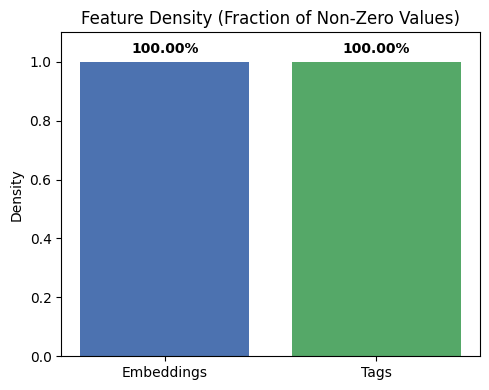

Embedding Density: 100.00%
Tag Density:       100.00%

Testing 7 C values with lbfgs solver...
  C= 0.001 | Train: 0.9204 | Val: 0.8167 | Gap: 0.1037
  C= 0.005 | Train: 0.9669 | Val: 0.8350 | Gap: 0.1319
  C= 0.010 | Train: 0.9827 | Val: 0.8383 | Gap: 0.1444
  C= 0.050 | Train: 0.9995 | Val: 0.8333 | Gap: 0.1661
  C= 0.100 | Train: 1.0000 | Val: 0.8300 | Gap: 0.1700
  C= 0.500 | Train: 1.0000 | Val: 0.8267 | Gap: 0.1733
  C= 1.000 | Train: 1.0000 | Val: 0.8200 | Gap: 0.1800

Best C: 0.01
Best validation accuracy: 0.8383


In [7]:
embed_density = (desc_train_emb_df.to_numpy() != 0).mean()
tag_density   = (tags_train_df.to_numpy() != 0).mean()

plt.figure(figsize=(5, 4))
plt.bar(['Embeddings', 'Tags'], [embed_density, tag_density],
        color=['#4C72B0', '#55A868'])
plt.title("Feature Density (Fraction of Non-Zero Values)")
plt.ylabel("Density")

for i, val in enumerate([embed_density, tag_density]):
    plt.text(i, val + 0.02, f"{val:.2%}", ha='center', va='bottom', fontweight='bold')

plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

print(f"Embedding Density: {embed_density:.2%}")
print(f"Tag Density:       {tag_density:.2%}")

scaler_hp = StandardScaler()
X_train_scaled = scaler_hp.fit_transform(X_train)
X_val_scaled = scaler_hp.transform(X_val)

C_values = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
results = []

print(f"\nTesting {len(C_values)} C values with lbfgs solver...")
for C in C_values:
    model = LogisticRegression(C=C, max_iter=1000, random_state=42, n_jobs=-1, solver='lbfgs')
    model.fit(X_train_scaled, y_train)
    train_score = model.score(X_train_scaled, y_train)
    val_score = model.score(X_val_scaled, y_val)
    results.append({'C': C, 'train_acc': train_score, 'val_acc': val_score, 'gap': train_score - val_score})
    print(f"  C={C:6.3f} | Train: {train_score:.4f} | Val: {val_score:.4f} | Gap: {train_score - val_score:.4f}")

results_df = pd.DataFrame(results)
best_idx = results_df['val_acc'].idxmax()
best_C = results_df.loc[best_idx, 'C']

print("\n" + "=" * 60)
print(f"Best C: {best_C}")
print(f"Best validation accuracy: {results_df.loc[best_idx, 'val_acc']:.4f}")
print("=" * 60)

## 6. K-Fold Cross Validation


Leakage-proof CV (val=originals only, train=originals(excl. fold) + augmented not derived from val):
  Fold 1: 0.8367 (83.67%)
  Fold 2: 0.8433 (84.33%)
  Fold 3: 0.8167 (81.67%)
  Fold 4: 0.8333 (83.33%)
  Fold 5: 0.7933 (79.33%)
  Fold 6: 0.8367 (83.67%)
  Fold 7: 0.8467 (84.67%)
  Fold 8: 0.7960 (79.60%)
--------------------
Mean: 0.8253 (82.53%)
Std:  0.0196 (1.96%)
Min:  0.7933 (79.33%)
Max:  0.8467 (84.67%)
95% Confidence Interval: [0.8118, 0.8389]


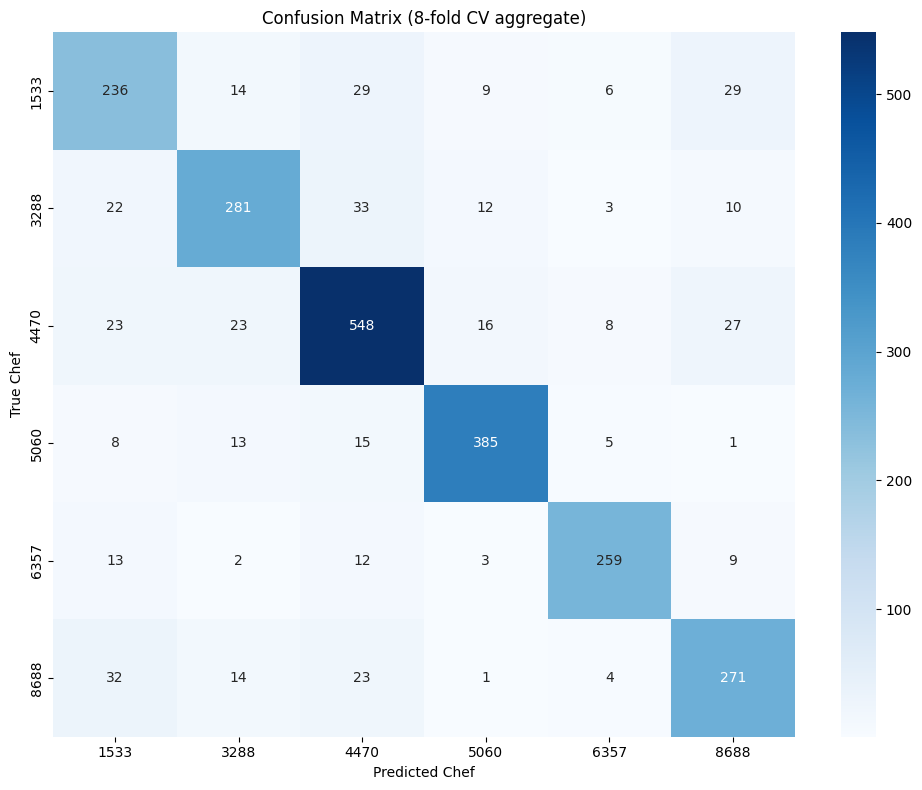


CLASSIFICATION REPORT
              precision    recall  f1-score   support

        1533     0.7066    0.7307    0.7184       323
        3288     0.8098    0.7784    0.7938       361
        4470     0.8303    0.8496    0.8398       645
        5060     0.9038    0.9016    0.9027       427
        6357     0.9088    0.8691    0.8885       298
        8688     0.7810    0.7855    0.7832       345

    accuracy                         0.8253      2399
   macro avg     0.8234    0.8192    0.8211      2399
weighted avg     0.8263    0.8253    0.8257      2399


TP / FP / TN / FN STATS PER CLASS
Class 1533: TP=236, FP=98, TN=1978, FN=87
Class 3288: TP=281, FP=66, TN=1972, FN=80
Class 4470: TP=548, FP=112, TN=1642, FN=97
Class 5060: TP=385, FP=41, TN=1931, FN=42
Class 6357: TP=259, FP=26, TN=2075, FN=39
Class 8688: TP=271, FP=76, TN=1978, FN=74


In [8]:

# Originals only for validation candidates
orig_mask = ~train_meta['is_augmented']
orig_idx = X_train.index[orig_mask]

X_orig = X_train.loc[orig_idx]
y_orig = y_train.loc[orig_idx]

skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
fold_scores = []
all_preds = []
all_true = []

print("\nLeakage-proof CV (val=originals only, train=originals(excl. fold) + augmented not derived from val):")
for fold, (tr_i, va_i) in enumerate(skf.split(X_orig, y_orig), 1):
    val_idx = X_orig.index[va_i]          # original rows for validation
    tr_orig_idx = X_orig.index[tr_i]      # original rows for training

    # augmented rows whose parent is NOT in validation fold
    aug_ok_mask = (train_meta['is_augmented']) & (~train_meta['parent_id'].isin(val_idx))
    tr_aug_idx = X_train.index[aug_ok_mask]

    # final train = originals (train part) + safe augmented
    tr_idx_all = tr_orig_idx.union(tr_aug_idx)

    X_tr = X_train.loc[tr_idx_all]
    y_tr = y_train.loc[tr_idx_all]
    X_va = X_train.loc[val_idx]
    y_va = y_train.loc[val_idx]

    # scale **from training only**
    scaler_cv = StandardScaler()
    X_tr_s = scaler_cv.fit_transform(X_tr)
    X_va_s = scaler_cv.transform(X_va)

    model_cv = LogisticRegression(C=best_C, max_iter=1000, random_state=42, n_jobs=-1, solver='lbfgs')
    model_cv.fit(X_tr_s, y_tr)
    preds = model_cv.predict(X_va_s)

    all_preds.extend(preds)
    all_true.extend(y_va)

    acc = accuracy_score(y_va, preds)
    fold_scores.append(acc)
    print(f"  Fold {fold}: {acc:.4f} ({acc:.2%})")

print("-" * 20)
mean_acc = np.mean(fold_scores)
std_acc = np.std(fold_scores)
n_folds = len(fold_scores)
se = std_acc / np.sqrt(n_folds)
ci_low = mean_acc - 1.96 * se
ci_high = mean_acc + 1.96 * se

print(f"Mean: {mean_acc:.4f} ({mean_acc:.2%})")
print(f"Std:  {std_acc:.4f} ({std_acc:.2%})")
print(f"Min:  {np.min(fold_scores):.4f} ({np.min(fold_scores):.2%})")
print(f"Max:  {np.max(fold_scores):.4f} ({np.max(fold_scores):.2%})")
print(f"95% Confidence Interval: [{ci_low:.4f}, {ci_high:.4f}]")

# ===========================
# CONFUSION MATRIX + METRICS
# ===========================

# Convert to numpy arrays
all_true = np.array(all_true)
all_preds = np.array(all_preds)

labels_sorted = np.unique(y_train)
cm = confusion_matrix(all_true, all_preds, labels=labels_sorted)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_sorted, yticklabels=labels_sorted)
plt.xlabel("Predicted Chef")
plt.ylabel("True Chef")
plt.title("Confusion Matrix (8-fold CV aggregate)")
plt.tight_layout()
plt.show()

# Classification report
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(all_true, all_preds, digits=4))

# ===========================
# TP, FP, TN, FN per class
# ===========================
print("\n" + "=" * 60)
print("TP / FP / TN / FN STATS PER CLASS")
print("=" * 60)

for i, cls in enumerate(labels_sorted):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    print(f"Class {cls}: TP={TP}, FP={FP}, TN={TN}, FN={FN}")